<a href="https://colab.research.google.com/github/atik666/BCI/blob/main/BCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tensorflow import keras
from keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = np.load("/content/drive/MyDrive/Colab/BCI/BCI.npy")
label = pd.read_excel('/content/drive/MyDrive/Colab/BCI/label.xlsx', header = None)
label = label.to_numpy().astype('float32')
label = label - 1

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_rem, y_train, y_rem = train_test_split(data,label, train_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5)
print(X_train.shape), print(y_train.shape)
print(X_val.shape), print(y_val.shape)
print(X_test.shape), print(y_test.shape)

(216, 224, 224, 3)
(216, 1)
(72, 224, 224, 3)
(72, 1)
(72, 224, 224, 3)
(72, 1)


(None, None)

In [5]:
IMAGE_SHAPE = (224, 224, 3)
      
model_name = "inception_v3"
feature_extractor_model="https://tfhub.dev/google/tf2-preview/%s/feature_vector/4" %model_name

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=IMAGE_SHAPE, trainable=False)
       
num_class = 4

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 39s 777ms/step - loss: 1.7447 - accuracy: 0.2546 - val_loss: 1.4994 - val_accuracy: 0.2639
Epoch 2/50
7/7 [==============================] - 2s 259ms/step - loss: 1.4762 - accuracy: 0.2361 - val_loss: 1.4355 - val_accuracy: 0.2222
Epoch 3/50
7/7 [==============================] - 1s 218ms/step - loss: 1.4547 - accuracy: 0.2222 - val_loss: 1.4561 - val_accuracy: 0.2361
Epoch 4/50
7/7 [==============================] - 1s 217ms/step - loss: 1.4213 - 

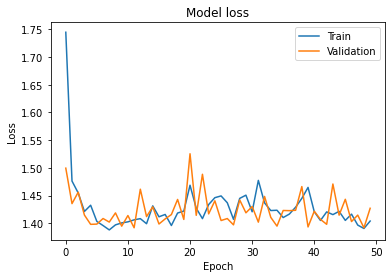

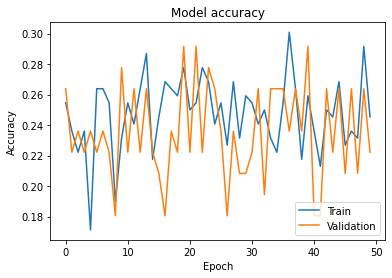

[[ 0  0  0 21]
 [ 0  0  0 18]
 [ 0  0  0 17]
 [ 0  0  0 16]]
acc :  22.22222222222222


In [6]:
model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_class)
])

model.summary()          
         
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
     
# Train your model using the early stopping callback
h_callback = model.fit(X_train, y_train, batch_size = 32,
           epochs = 50, validation_data = (X_val, y_val))

loss, acc= model.evaluate(X_test, y_test)
print('Test Accuracy: %f' % (acc*100))

def plot_loss(loss,val_loss):
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()
  
def plot_accuracy(acc,val_acc):
  # Plot training & validation accuracy values
  plt.figure()
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='lower right')
  plt.show()
  
# Plot train vs test loss during training
plot_loss(h_callback.history['loss'], h_callback.history['val_loss'])

# Plot train vs test accuracy during training
plot_accuracy(h_callback.history['accuracy'], h_callback.history['val_accuracy'])

from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf = confusion_matrix(y_test, y_pred)
print(conf)
print('acc : ', np.trace(conf)/np.sum(conf)*100)